## Predict

In [1]:
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow_addons as tfa
from segmentation_models import Unet, FPN
import pandas as pd
import tifffile as tiff
import cv2
import numpy as np
import matplotlib.pyplot as plt

Segmentation Models: using `tf.keras` framework.


In [2]:
VER = "v69"
PARAMS = {
    "version": VER,
    "folds": 1,
    "img_size": 256,
    "resize": 4,
    "batch_size" : 20,
    "epochs": 2,
    "patience": 20,
    "backbone": "efficientnetb2",# efficientnetbX, resnet34/50, resnext50, seresnet34, seresnext
    "loss": "bce_dice",
    "mirror": False,
    "umodel" : "unet",
    "bce_weight": 1.,
    "shift": True,
    "pseudo":"",
    "lr": 0.0002
}
DATA_PATH = "../input/hubmap-kidney-segmentation"

if not PARAMS["mirror"]:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    STRATEGY = tf.distribute.get_strategy()
else:
    STRATEGY = tf.distribute.MirroredStrategy()


MDLS_PATH = f"./models_{VER}"

In [3]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1])
    for m, enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) - 1
            length = int(s[ 2 * i + 1])
            img[start : start + length] = 1 + m
        return img.reshape(shape).T

In [4]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    return (1 - dice_coef(y_true, y_pred))

def bce_dice_loss(y_true, y_pred):
    return PARAMS["bce_weight"] * binary_crossentropy(y_true, y_pred) + \
        (1 - PARAMS["bce_weight"]) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type = "bce_dice", umodel = "unet", classes = 1, lr = PARAMS["lr"]):
    with STRATEGY.scope():
        if loss_type == "bce_dice":
            loss = bce_dice_loss
            
        else:
            raise AttributeError("loss mode parameter error")
            
        if umodel == "unet":
            model = Unet(backbone_name = backbone, encoder_weights = "imagenet",
                        input_shape = input_shape,
                        classes = classes, activation = "sigmoid")
        elif umodel == "fpn":
            model = FPN(backbone_name = backbone, encoder_weights = "imagenet",
                       input_shape = input_shape,
                       classes = classes, activation = "sigmoid")
        else:
            raise AttributeError("umodel mode parameter error")
        
        model.compile(
            optimizer = tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate = lr),
                sync_period = max(6, int(PARAMS["patience"] / 4))
            ),
            loss = loss,
            metrics = [dice_coef]
        )
        return model

In [5]:
larger = 4

test_models = []
for n_fold in list(range(PARAMS["folds"])):
    checkpoint_path = f"{MDLS_PATH}/model_{n_fold}.hdf5"
    print(checkpoint_path)
    model_lrg = get_model(
        PARAMS["backbone"],
        input_shape = (PARAMS["img_size"] * larger, PARAMS["img_size"] * larger, 3),
        loss_type = PARAMS["loss"],
        umodel = PARAMS["umodel"]
    )
    model_lrg.load_weights(checkpoint_path) # or .set_weights(model.get_weights()) from smaller model
    test_models.append(model_lrg)

./models_v69/model_0.hdf5


C:\Users\apist\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


(31278, 25794, 3) (31278, 25794)


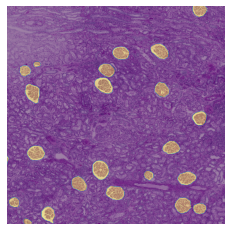

In [6]:
df_masks = pd.read_csv(f"{DATA_PATH}/train.csv").set_index("id")
img_num = 0
resize = PARAMS["resize"]
shft = .6
wnd = PARAMS["img_size"] * larger
img = tiff.imread(os.path.join(f"{DATA_PATH}/train", df_masks.index[img_num] + ".tiff"))
if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1,2,0))
mask = enc2mask(df_masks.iloc[img_num], (img.shape[1], img.shape[0]))
print(img.shape, mask.shape)
img = cv2.resize(img,
                (img.shape[1] // resize, img.shape[0] // resize),
                interpolation = cv2.INTER_AREA)
mask = cv2.resize(mask,
                 (mask.shape[1] // resize, mask.shape[0] // resize),
                 interpolation = cv2.INTER_NEAREST)
img = img[int(img.shape[0] * shft) : int(img.shape[0] * shft) + wnd,
          int(img.shape[1] * shft) : int(img.shape[1] * shft) + wnd,
          :]
mask = mask[int(mask.shape[0] * shft) : int(mask.shape[0] * shft) + wnd,
             int(mask.shape[1] * shft) : int(mask.shape[1] * shft) + wnd]
plt.figure(figsize = (4,4))
plt.axis("off")
plt.imshow(img)
plt.imshow(mask, alpha = 0.4)
plt.show()

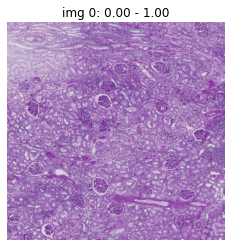

In [10]:
fig, axes = plt.subplots(figsize = (16, 4), nrows = 1, ncols = len(test_models))
for j in range(len(test_models)):
    mask_lrg = test_models[j].predict(img[np.newaxis,] / 255)
    
    axes.imshow(img)
    #axes.imshow(np.squeeze(mask_lrg), alpha = 0.4)
    
    axes.set_title(f"img {j}: {np.min(mask_lrg):.2f} - {np.max(mask_lrg):.2f}")
    axes.axis("off")
plt.show()

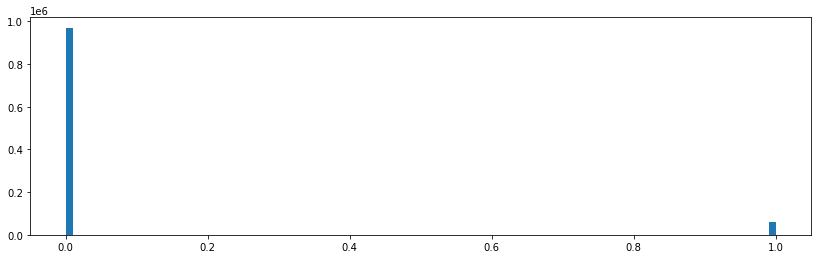

In [8]:
plt.figure(figsize = (14,4))
plt.hist(mask_lrg.flatten(), bins = 100)
plt.show()

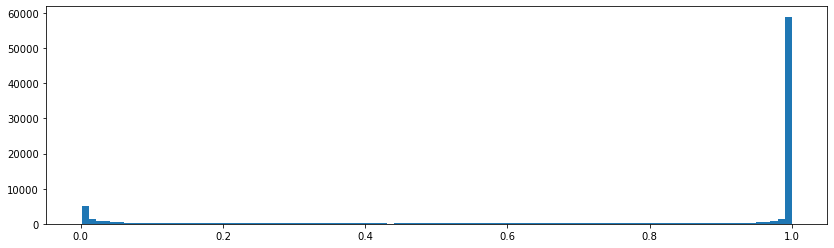

In [9]:
plt.figure(figsize = (14,4))
plt.hist(np.where(mask_lrg < 10e-4, np.nan, mask_lrg).flatten(), bins = 100)
plt.show()